# Assignment 5

**Submission deadlines:**
- get at least 4 points by Tuesday, 8.06 
- remaining points: last lab session of the semester

**Points:** Aim to get 12 out of 16 possible points.


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Generating 2 Moons data
Consider the 2D moons dataset generated in the starter code below. 

Train the following models: VAE, GAN, RealNVP. 

For each model visualize how the latent space is transformed into data points. Train a model with 2D latent space. Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

## Tasks:
1. [4p] Variational Autoencoder (VAE)

  Please use the following probability distributions:
    
  $$
    \begin{split}
    p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
    p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
    \end{split}
  $$

  where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible? 

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?

2. [3p] Generative Adversarial Network (GAN)

  Please use either a standard normal distribution for the latent space or a uniform distribution.

  **Answer these questions:**
  - Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

3. [3p] Normalizing Flow (Real NVP model).

  The goal of Normalizing Flows is to learn invertible transformation between complex data distribution and some simple one, i.e. multivariate isotropic Gaussian. Since the latter is continuous, and our dataset is finite (hence in fact forms a discrete distribution, because you can memorize all observed values), we need to perform *dequantization*, that is add random noise to data at every iteration to train the model on an infinite stream of data. This is especially important in Problem 2 when RealNVP is applied to the MNIST data.

    **Answer these questions:**
  - Scale the input data by 0.01. Why is the negative log-likelihood negative?
  - For a few 2 moon widths compare the negative log-likelihood of the data with the values obtained with the VAE and present results in a table. How do they compare? Please note, that GAN's do not return likelihood computation.


# Problem 2: Generating MNIST

Next, choose one of the generative models (VAE, RealNVP, or GAN) and do the following using the MNIST dataset:

##Tasks
1. [2p] Train the model. Visualize generated samples (and test/train data reconstructions if you chose VAE).

Please properly define $p(x|z)$: when using a VAE, you can binarize the data and predict binary variables. For RealNVP, you can normalize the data to the 0-1 range, and add uniform noise $[0,1/255]$ to dequantize intensity values. GAN does not assume an output probability distribution and you may use raw data.

2. [1p] Linearly interpolate between two points in the latent space. Generate images from them and intermediate points. 

3. [1p] Try a different interpolation method, i.e. instead of going in a straight line from one point to another, follow the spherical curve of prior Gaussian distribution.

4. [2p] It is sometimes desirable to make use of available labels to gain control over classes of generated samples. Create a conditional generative model of your choice by injecting one-hot embeddings into the proper component(s). An example is [Conditional GAN](https://arxiv.org/abs/1411.1784), and its idea is applicable to other methods.


# Starter code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cuda"

## Data

In [ ]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [ ]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


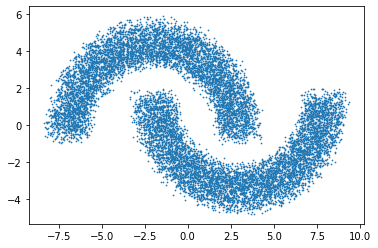

In [ ]:
moons = generate_moons(width=1.0)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

## VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var

    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the  the reparametrization trick.
        # TODO
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        epsilon = torch.randn_like(z_log_var) # ~ N(0, 1) # requires_grad=False by default
        sampled_z = z_mu + torch.exp(z_log_var / 2) * epsilon # log(variance) -> stdev
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [ ]:
import math

def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    """ what about the log? """
    # so we want to simply calculate https://en.wikipedia.org/wiki/Gaussian_function for given arguments?
    # multivariate normal
    # print(
    #     x.shape,
    #     mu,.shape,
    #     log_var.shape
    # )
    # var = torch.exp(log_var)
    # # stddev = torch.exp(z_log_var / 2) # ??
    # log_stddev = log_var * 0.5
    # return -((x - mu) ** 2) / (2 * var) - log_stddev - math.log(math.sqrt(2 * math.pi)) # from implementation of torch.distributions.Normal.log_prob https://pytorch.org/docs/stable/_modules/torch/distributions/normal.html#Normal.log_prob
    # std = exp
    m = torch.distributions.Normal(mu, torch.exp(log_var/2))
    return -m.log_prob(x)

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2): # https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/
    return (
        log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / (log_var2.exp()) - 1
    ) / 2


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negative log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    # we want to have https://arxiv.org/pdf/1312.6114.pdf rhs of equation no 10 here
    # hmmm, so we assume x|z ~ N(mu, var)
    # and we want (negative) likelihood of this x|z thing

    # I = torch.diag(predicted_x_log_var)

    return torch.mean(
        gaussian_negative_log_likelihood(real_x, predicted_x_mu, predicted_x_log_var)
    )
    # return torch.mean(
    #     torch.stack([
    #           gaussian_negative_log_likelihood(
    #               real_x,
    #               predicted_x_mu,
    #               predicted_x_log_var
    #           )
    #         ]
    #         for (predicted_x_mu, predicted_x_log_var, real_x) in zip(predicted_x_mu, predicted_x_log_var, real_x)
    #     )
    # )


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).
    """
    return torch.mean( # mean of batch values
            kullback_leibler_divergence_between_two_gaussians(
                z_mu,
                z_log_var,
                torch.zeros_like(z_mu).to(device),
                torch.zeros_like(z_log_var).to(device) # log
                ),
    )


In [ ]:
hid_dim = 64
z_dim = 2
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

Epoch: 0 loss: 7.5499 recon_loss: 7.5051 kl_loss: 0.0448 avg mean: -0.0989 avg std: 1.0713


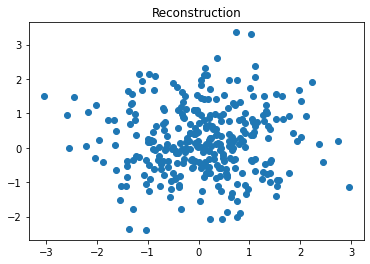

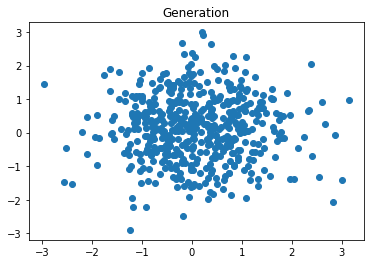

Epoch: 200 loss: 2.4808 recon_loss: 1.3987 kl_loss: 1.0821 avg mean: -0.0414 avg std: 0.3673


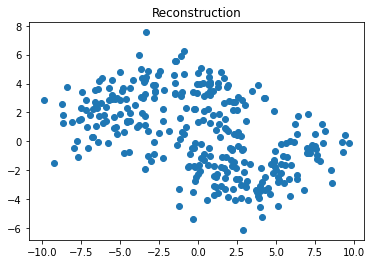

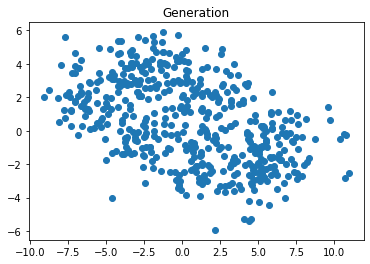

Epoch: 400 loss: 2.4502 recon_loss: 1.3662 kl_loss: 1.0840 avg mean: -0.0511 avg std: 0.3763


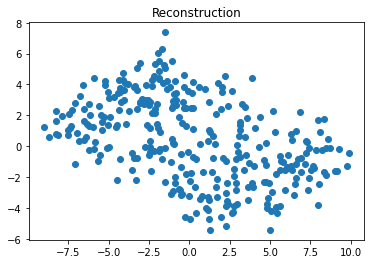

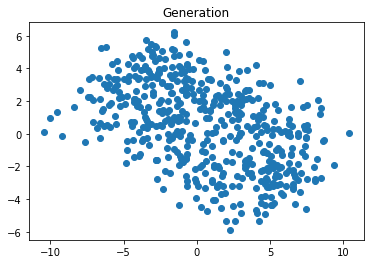

Epoch: 600 loss: 2.4342 recon_loss: 1.3312 kl_loss: 1.1030 avg mean: 0.0191 avg std: 0.3723


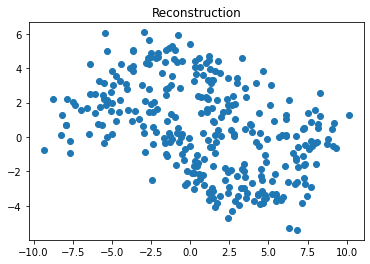

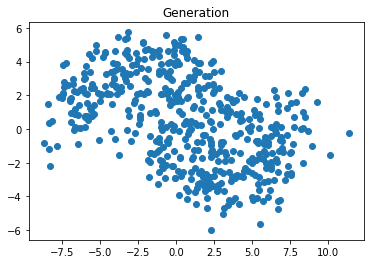

Epoch: 800 loss: 2.4075 recon_loss: 1.2138 kl_loss: 1.1937 avg mean: -0.0237 avg std: 0.3683


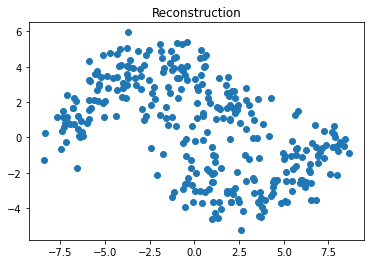

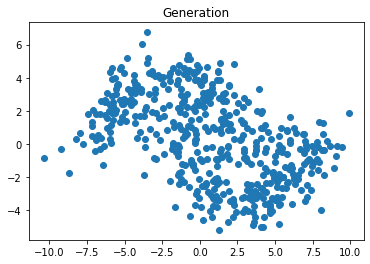

Epoch: 1000 loss: 2.3851 recon_loss: 1.1131 kl_loss: 1.2720 avg mean: 0.0402 avg std: 0.3482


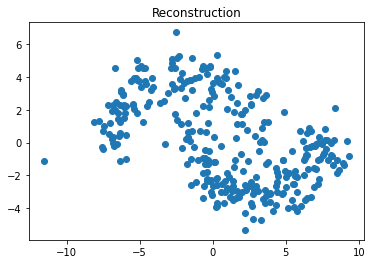

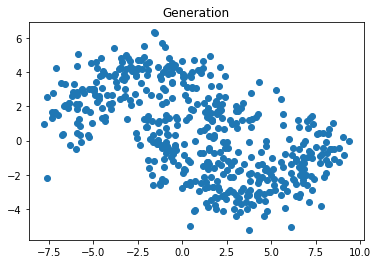

Epoch: 1200 loss: 2.3741 recon_loss: 1.0086 kl_loss: 1.3655 avg mean: 0.0086 avg std: 0.3267


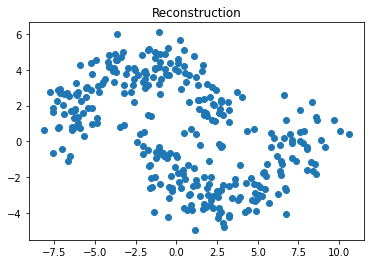

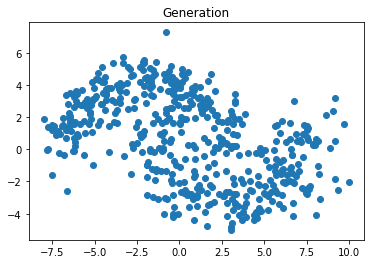

Epoch: 1400 loss: 2.3573 recon_loss: 0.9039 kl_loss: 1.4534 avg mean: 0.0070 avg std: 0.3120


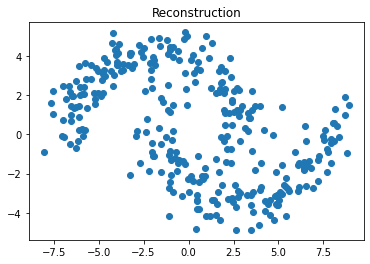

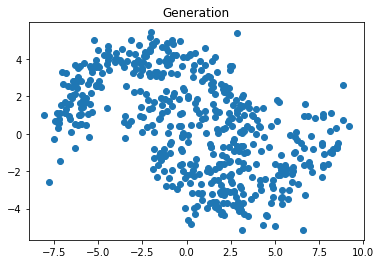

Epoch: 1600 loss: 2.3508 recon_loss: 0.8488 kl_loss: 1.5019 avg mean: -0.0007 avg std: 0.2920


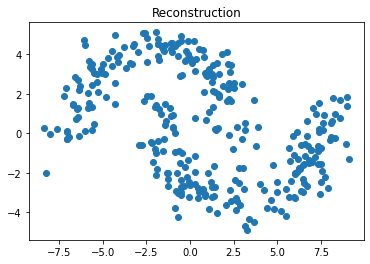

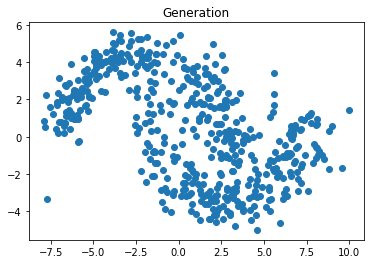

Epoch: 1800 loss: 2.3473 recon_loss: 0.7760 kl_loss: 1.5713 avg mean: 0.0328 avg std: 0.2643


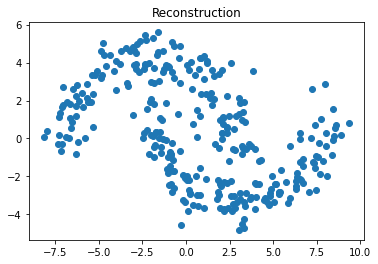

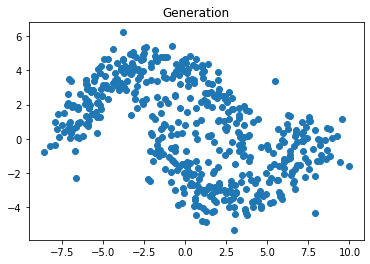

Epoch: 2000 loss: 2.3354 recon_loss: 0.7029 kl_loss: 1.6324 avg mean: -0.0629 avg std: 0.2645


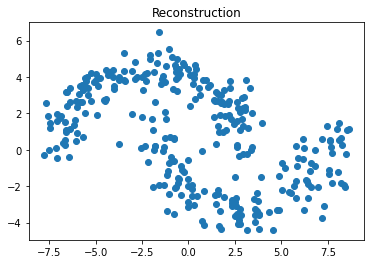

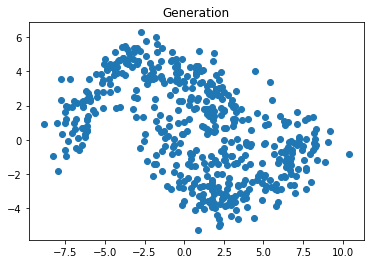

Epoch: 2200 loss: 2.3374 recon_loss: 0.6151 kl_loss: 1.7223 avg mean: -0.0503 avg std: 0.2313


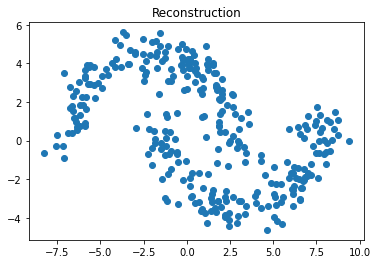

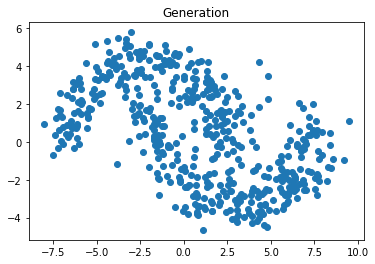

Epoch: 2400 loss: 2.3218 recon_loss: 0.5218 kl_loss: 1.8000 avg mean: 0.0127 avg std: 0.2210


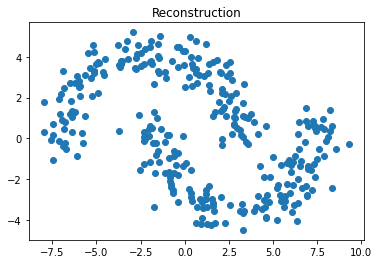

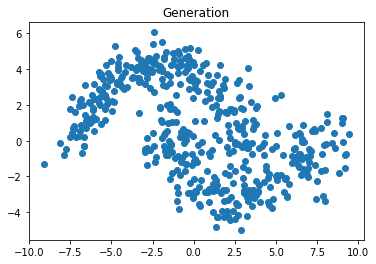

Epoch: 2600 loss: 2.3115 recon_loss: 0.4502 kl_loss: 1.8613 avg mean: 0.0202 avg std: 0.2067


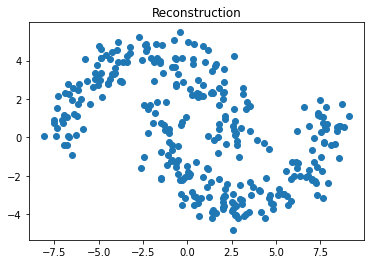

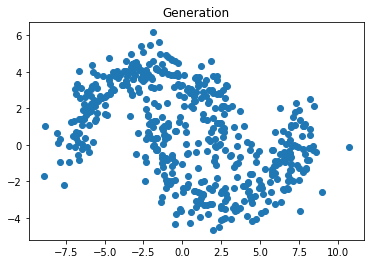

Epoch: 2800 loss: 2.3193 recon_loss: 0.3803 kl_loss: 1.9390 avg mean: -0.0445 avg std: 0.1951


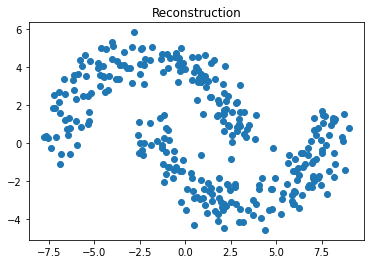

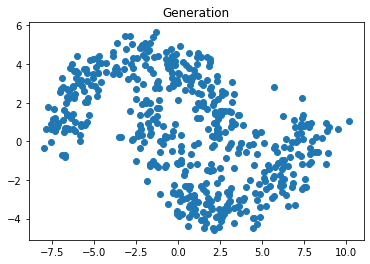

Epoch: 3000 loss: 2.3080 recon_loss: 0.3075 kl_loss: 2.0005 avg mean: 0.0703 avg std: 0.1788


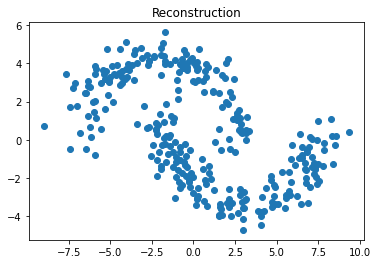

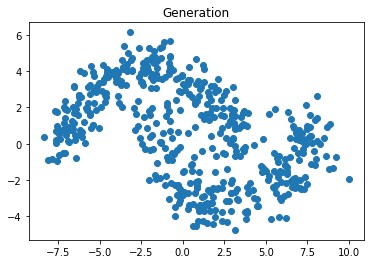

Epoch: 3200 loss: 2.3137 recon_loss: 0.2594 kl_loss: 2.0543 avg mean: -0.0275 avg std: 0.1821


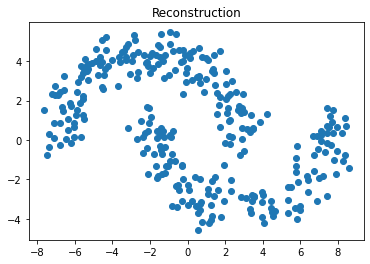

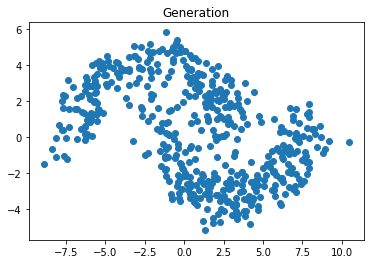

Epoch: 3400 loss: 2.3096 recon_loss: 0.2199 kl_loss: 2.0897 avg mean: 0.0103 avg std: 0.1636


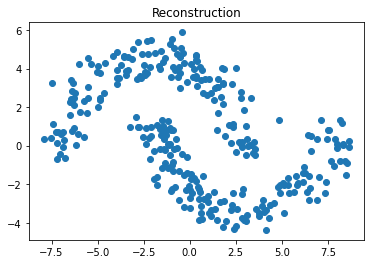

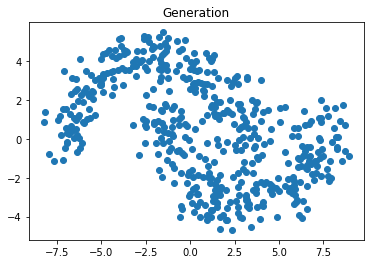

Epoch: 3600 loss: 2.2919 recon_loss: 0.1712 kl_loss: 2.1207 avg mean: 0.0388 avg std: 0.1686


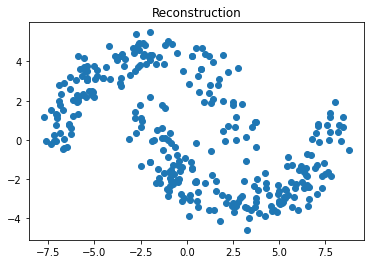

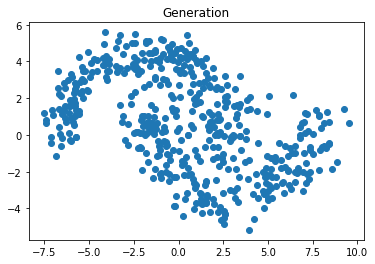

Epoch: 3800 loss: 2.3087 recon_loss: 0.1508 kl_loss: 2.1579 avg mean: 0.0668 avg std: 0.1602


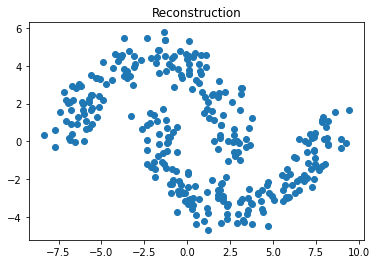

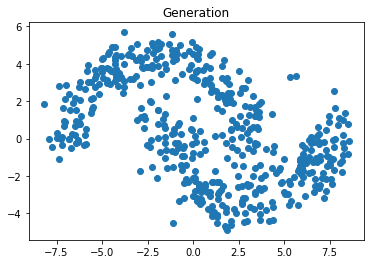

Epoch: 4000 loss: 2.2859 recon_loss: 0.1084 kl_loss: 2.1776 avg mean: 0.0613 avg std: 0.1579


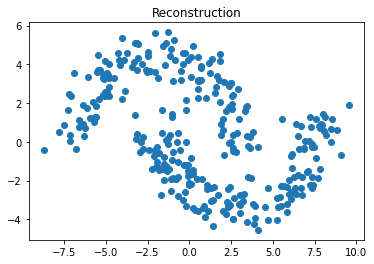

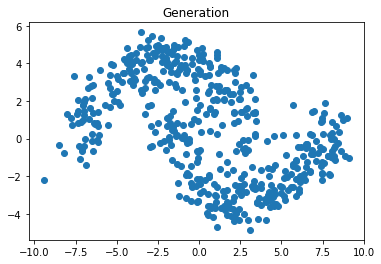

Epoch: 4200 loss: 2.3075 recon_loss: 0.0994 kl_loss: 2.2081 avg mean: 0.0493 avg std: 0.1531


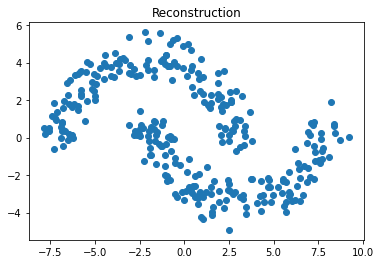

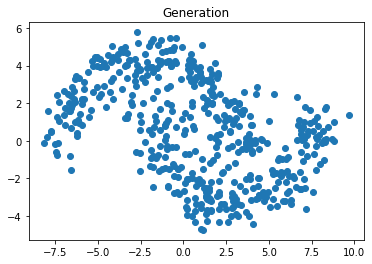

Epoch: 4400 loss: 2.2778 recon_loss: 0.0704 kl_loss: 2.2074 avg mean: -0.0190 avg std: 0.1565


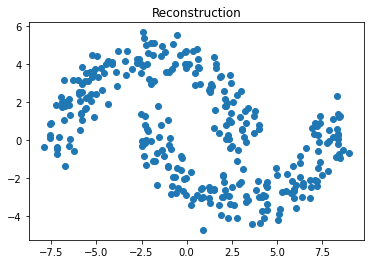

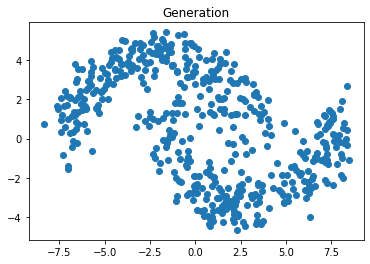

Epoch: 4600 loss: 2.2821 recon_loss: 0.0491 kl_loss: 2.2330 avg mean: -0.0105 avg std: 0.1527


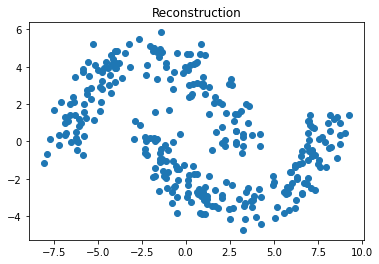

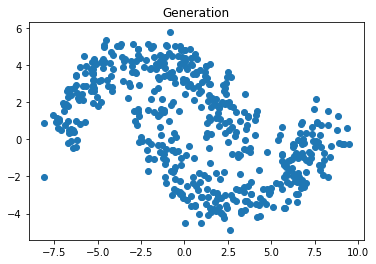

Epoch: 4800 loss: 2.2860 recon_loss: 0.0294 kl_loss: 2.2565 avg mean: 0.0388 avg std: 0.1477


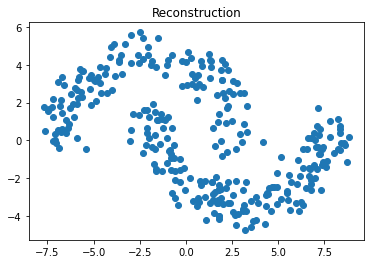

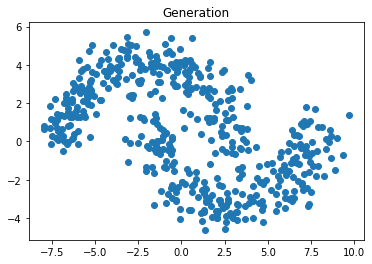

Epoch: 5000 loss: 2.2987 recon_loss: 0.0447 kl_loss: 2.2540 avg mean: -0.0174 avg std: 0.1438


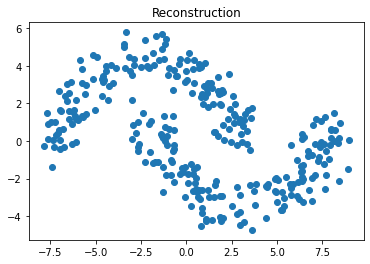

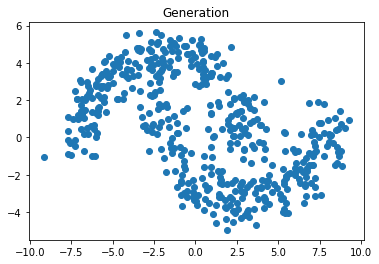

Epoch: 5200 loss: 2.2896 recon_loss: 0.0083 kl_loss: 2.2813 avg mean: -0.0016 avg std: 0.1441


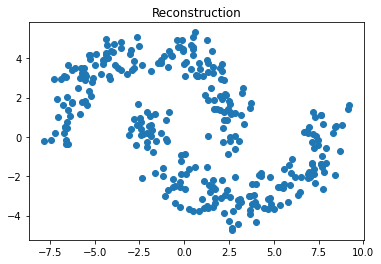

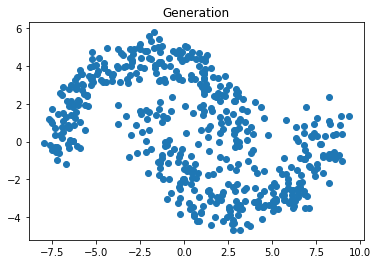

Epoch: 5400 loss: 2.2807 recon_loss: -0.0047 kl_loss: 2.2854 avg mean: 0.0555 avg std: 0.1475


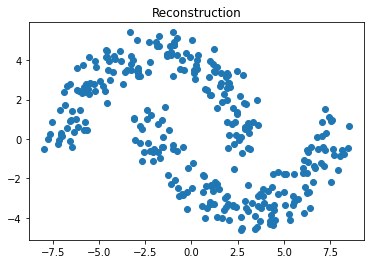

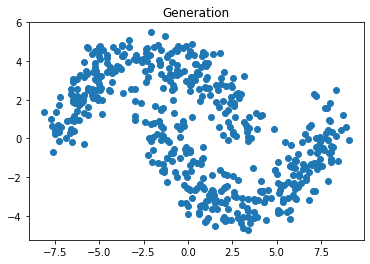

Epoch: 5600 loss: 2.2808 recon_loss: -0.0097 kl_loss: 2.2905 avg mean: 0.0135 avg std: 0.1416


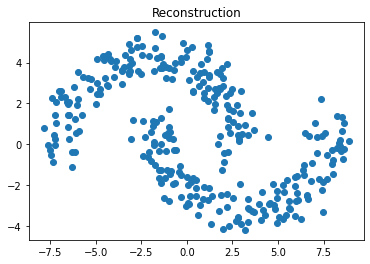

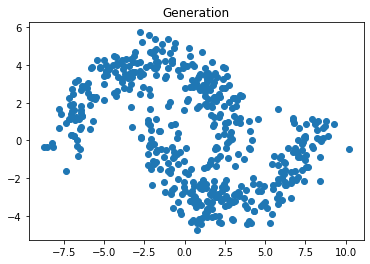

Epoch: 5800 loss: 2.2813 recon_loss: -0.0127 kl_loss: 2.2940 avg mean: -0.0676 avg std: 0.1455


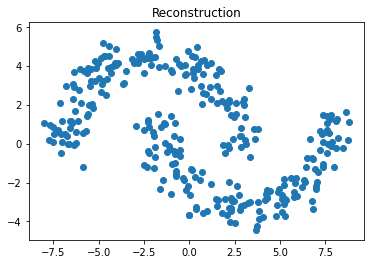

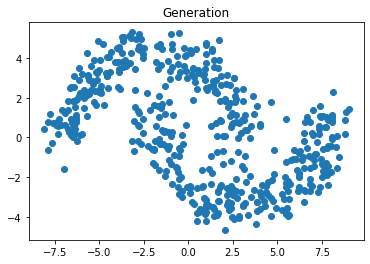

Epoch: 6000 loss: 2.2852 recon_loss: -0.0289 kl_loss: 2.3141 avg mean: -0.0278 avg std: 0.1398


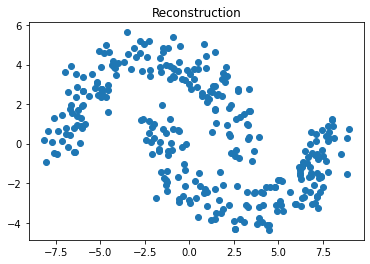

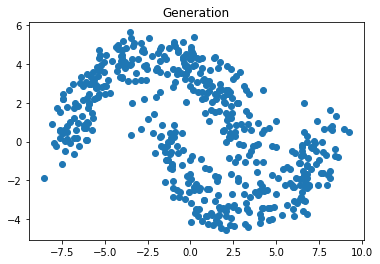

Epoch: 6200 loss: 2.2907 recon_loss: -0.0168 kl_loss: 2.3075 avg mean: -0.0017 avg std: 0.1440


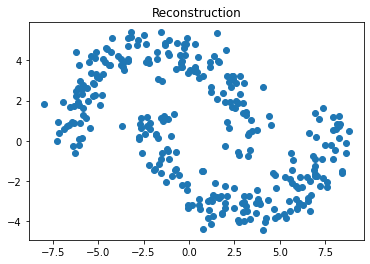

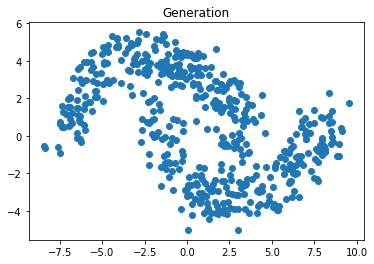

Epoch: 6400 loss: 2.2808 recon_loss: -0.0321 kl_loss: 2.3129 avg mean: 0.0332 avg std: 0.1440


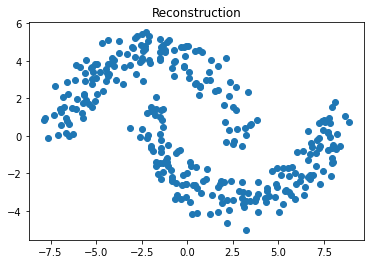

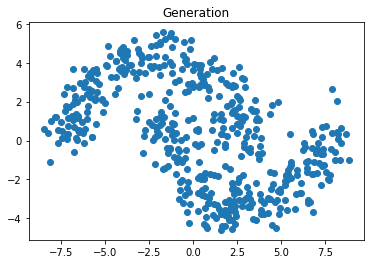

Epoch: 6600 loss: 2.2905 recon_loss: -0.0375 kl_loss: 2.3281 avg mean: -0.0380 avg std: 0.1387


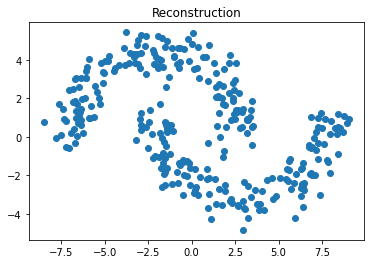

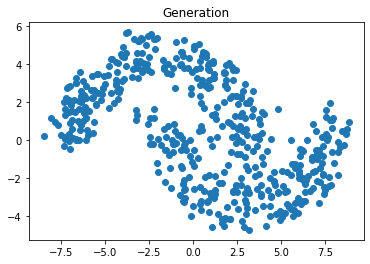

Epoch: 6800 loss: 2.2802 recon_loss: -0.0459 kl_loss: 2.3261 avg mean: -0.0418 avg std: 0.1431


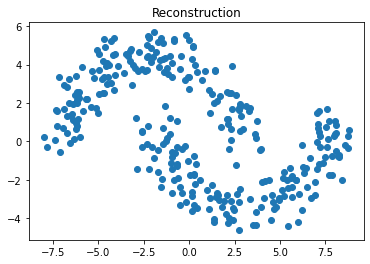

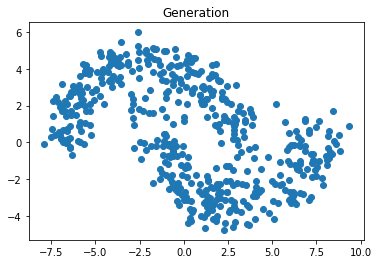

Epoch: 7000 loss: 2.2836 recon_loss: -0.0559 kl_loss: 2.3395 avg mean: 0.0357 avg std: 0.1371


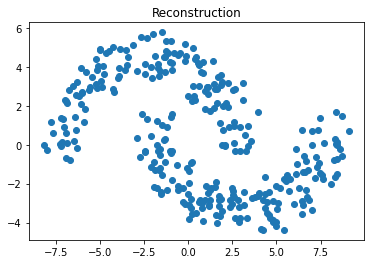

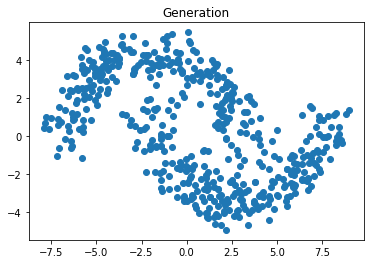

Epoch: 7200 loss: 2.2857 recon_loss: -0.0594 kl_loss: 2.3451 avg mean: 0.0293 avg std: 0.1339


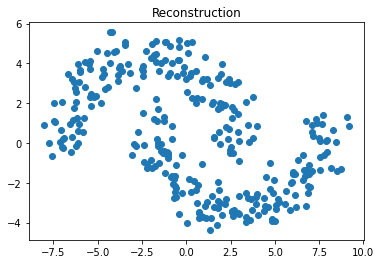

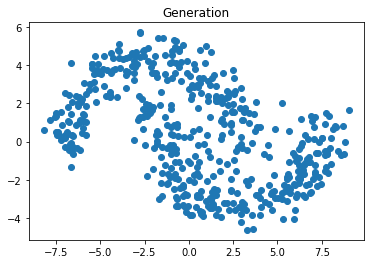

Epoch: 7400 loss: 2.2857 recon_loss: -0.0649 kl_loss: 2.3506 avg mean: 0.0203 avg std: 0.1360


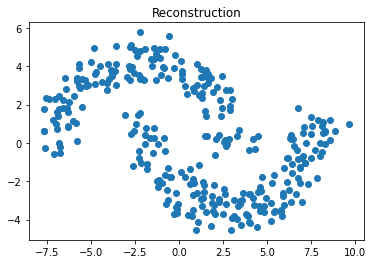

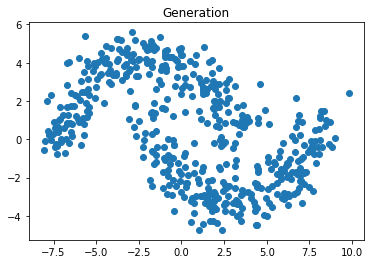

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

In [ ]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

Text(0.5, 1.0, 'Data in latent space')

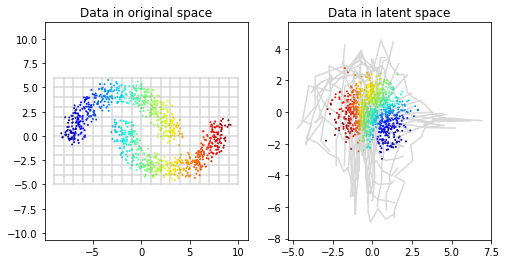

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data and the grid

enc_grid, _, _ = vae.encode(torch.from_numpy(grid).float().to(device))
enc_data, _, _ = vae.encode(torch.from_numpy(data).float().to(device))

enc_grid = enc_grid.cpu().detach().numpy()
enc_data = enc_data.cpu().detach().numpy()


plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

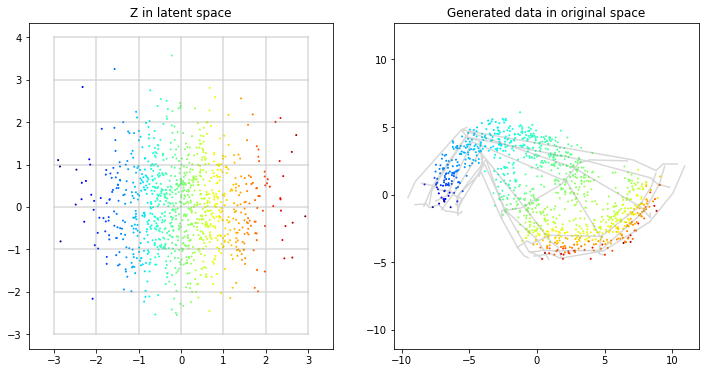

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid

x_gen_mu, x_gen_log_var       = vae.decode(latent_samples.to(device))
grid_gen_mu, grid_gen_log_var = vae.decode(torch.from_numpy(latent_grid).float().to(device))

x_gen    = torch.normal(x_gen_mu, torch.exp(x_gen_log_var / 2)).detach().to("cpu")
grid_gen = torch.normal(grid_gen_mu, torch.exp(grid_gen_log_var / 2)).detach().to("cpu")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# https://arxiv.org/pdf/1406.2661.pdf page 4
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    return torch.mean(
            # torch.log(1.0 - DG),
            torch.log(1.0 - DG + eps),
    )


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return -torch.mean(
            # torch.log(DR) + torch.log(1.0 - DG),
            torch.log(DR + eps) + torch.log(1.0 - DG + eps),
    )


In [ ]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

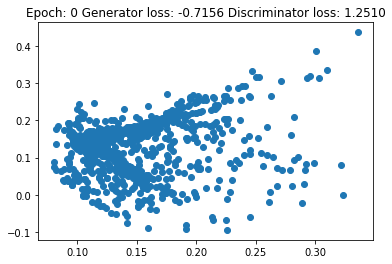

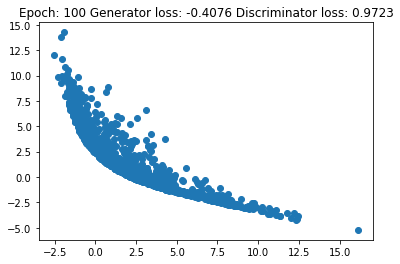

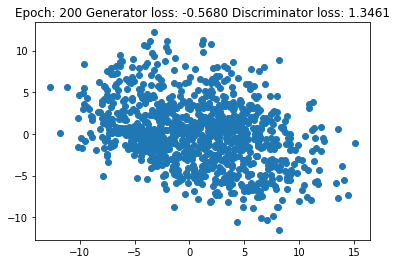

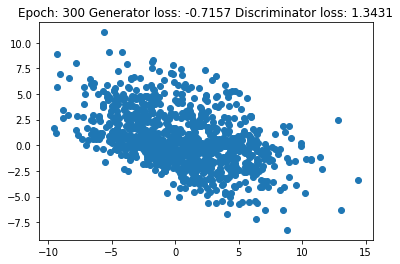

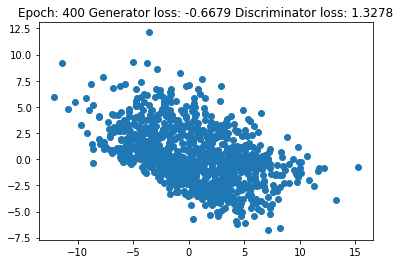

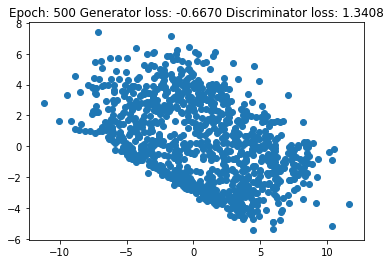

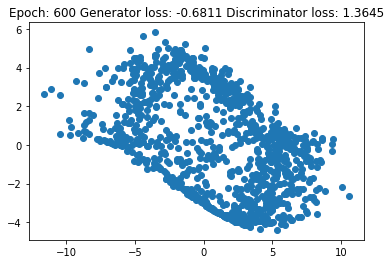

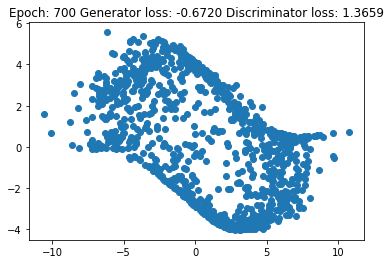

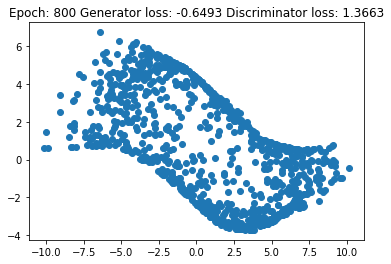

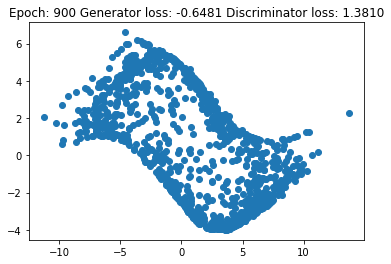

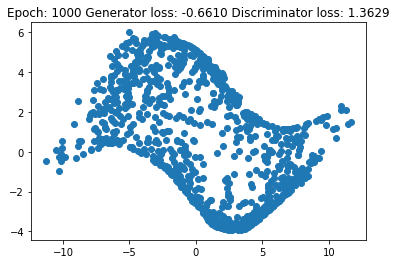

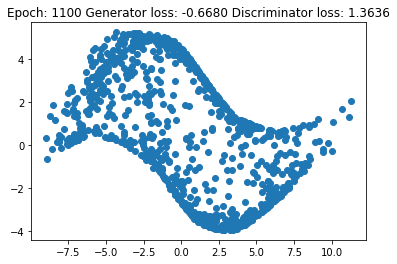

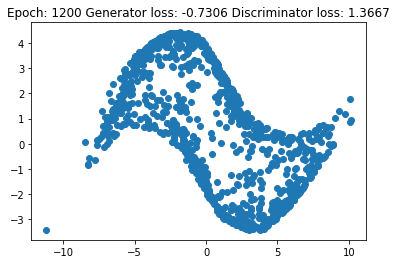

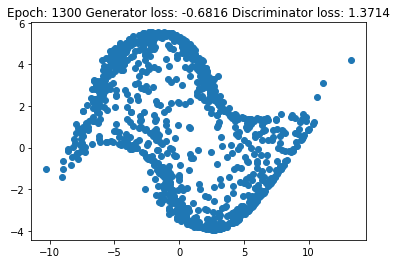

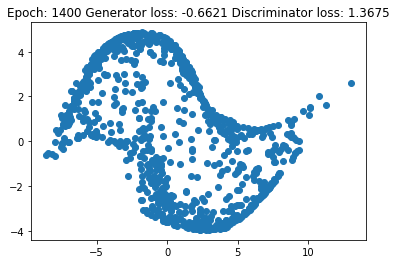

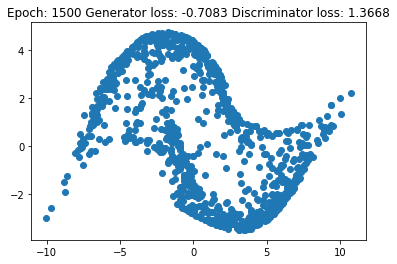

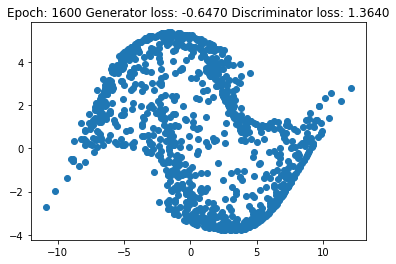

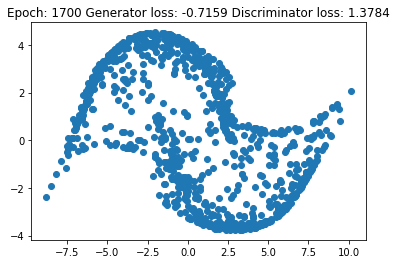

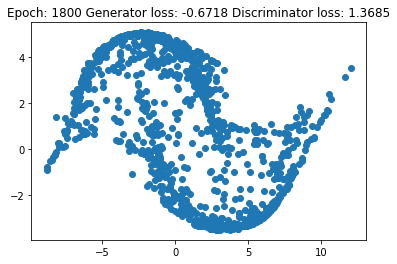

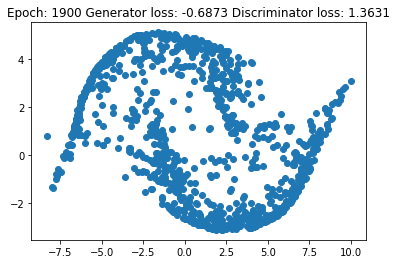

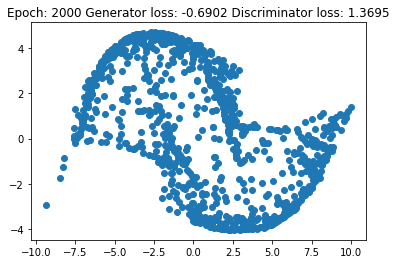

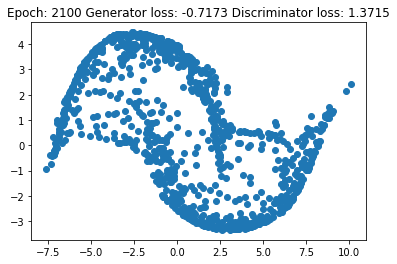

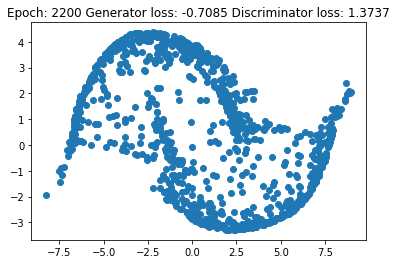

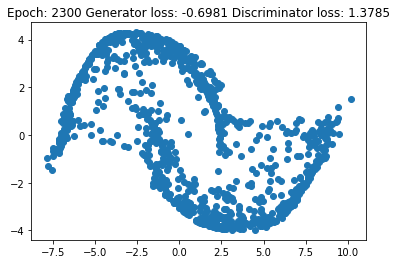

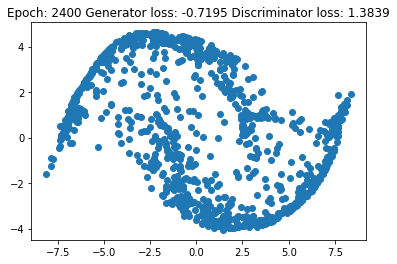

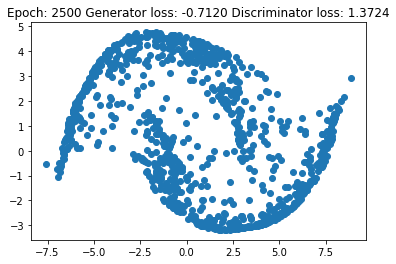

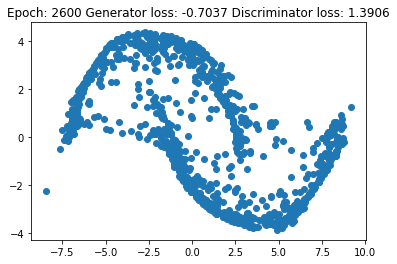

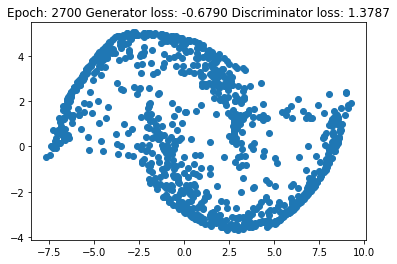

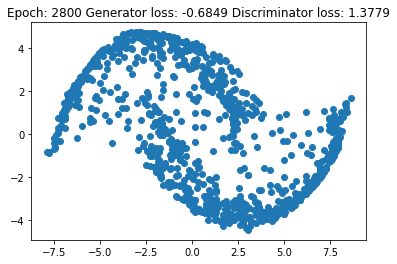

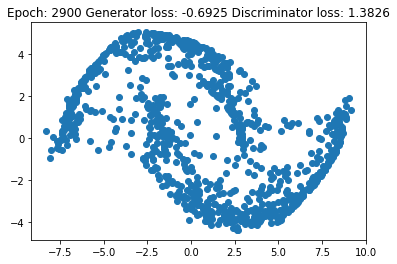

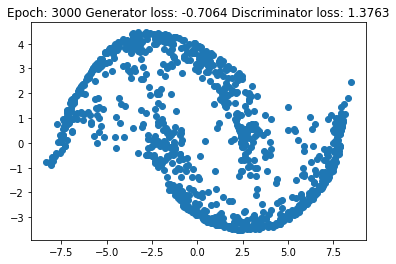

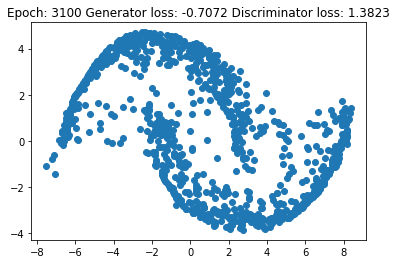

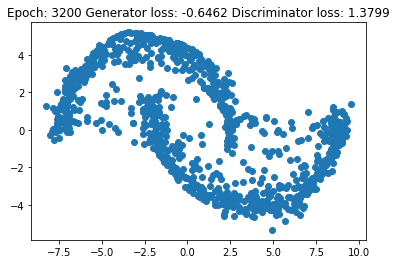

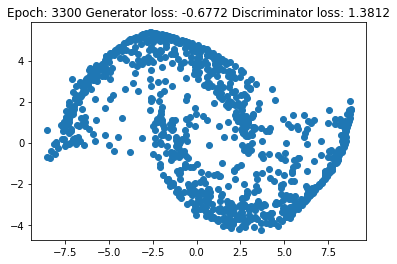

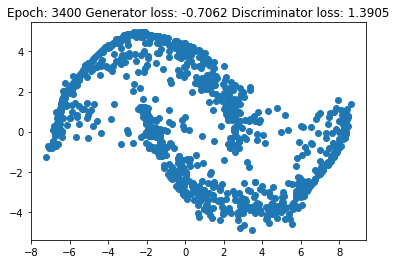

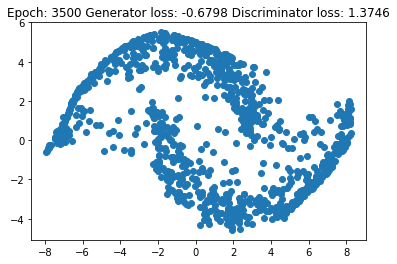

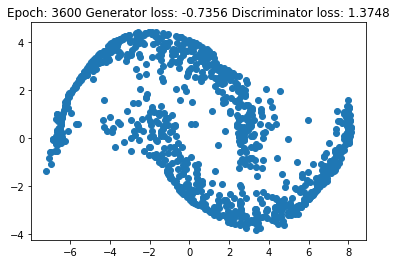

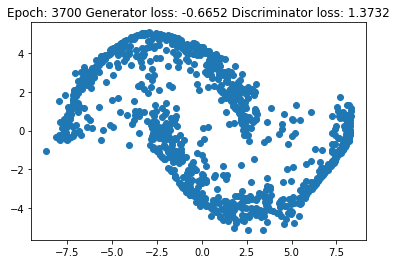

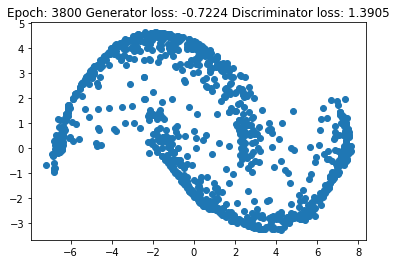

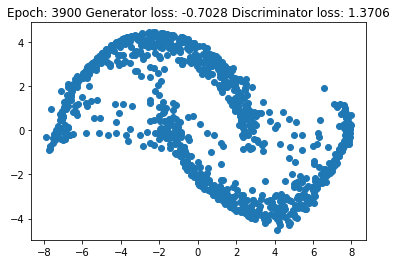

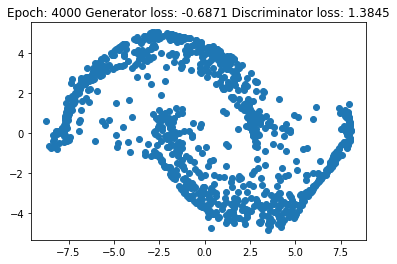

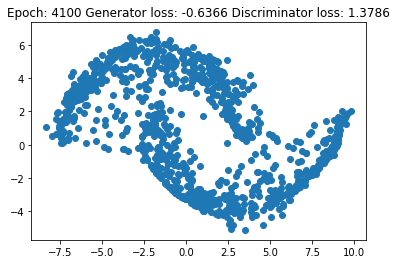

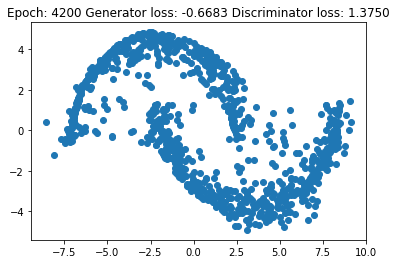

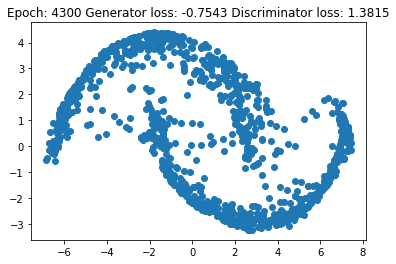

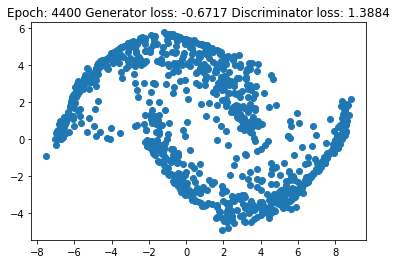

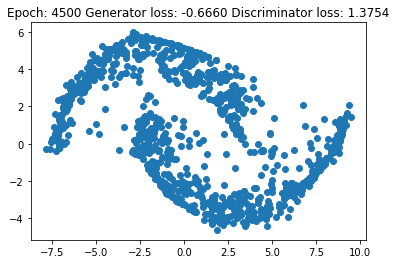

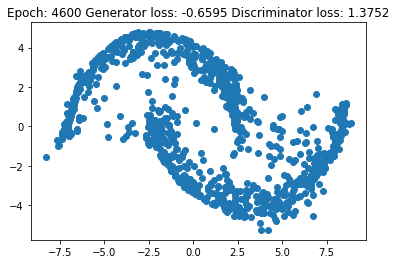

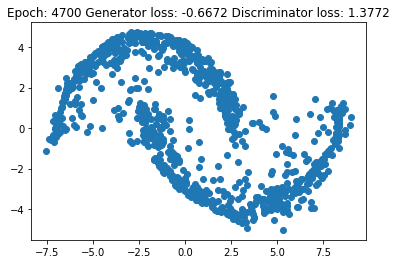

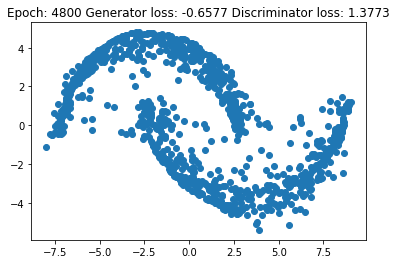

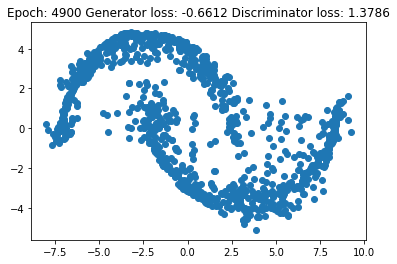

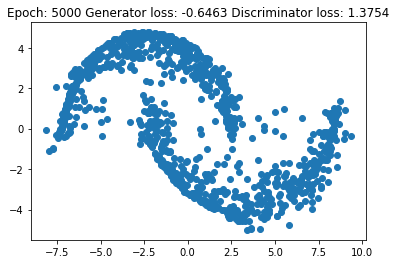

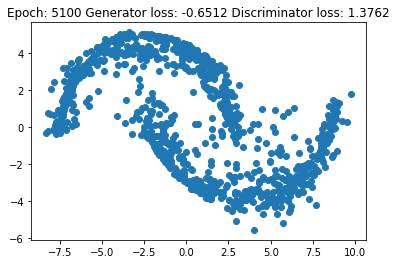

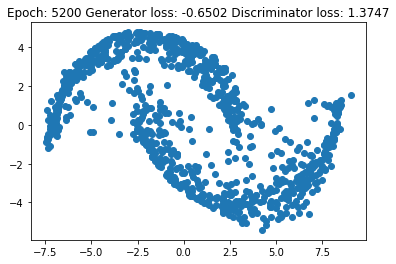

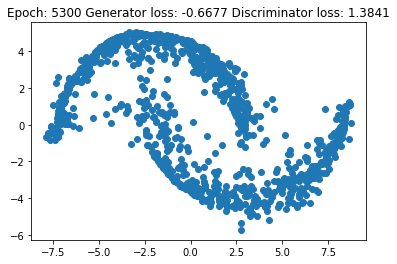

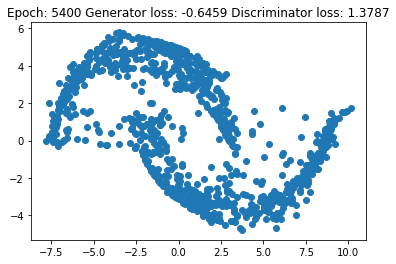

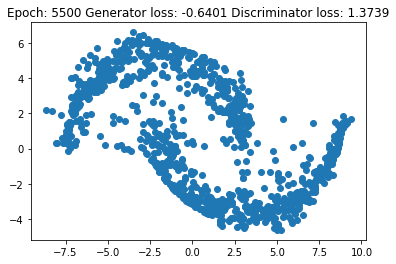

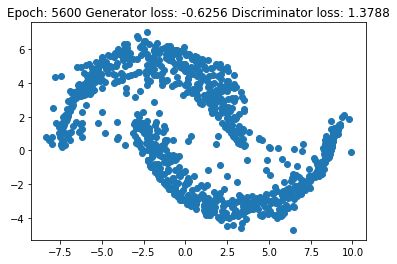

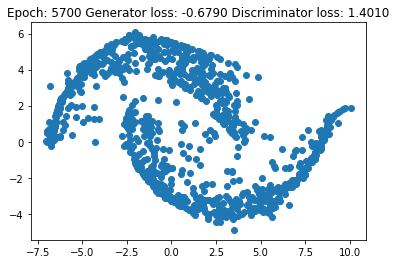

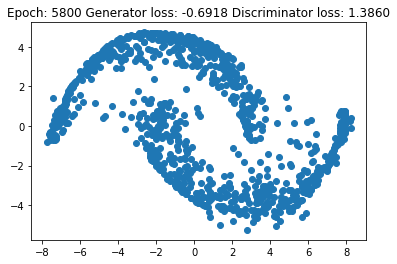

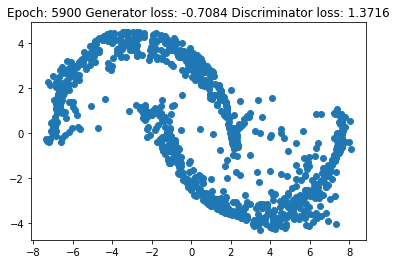

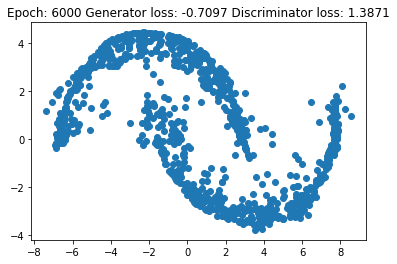

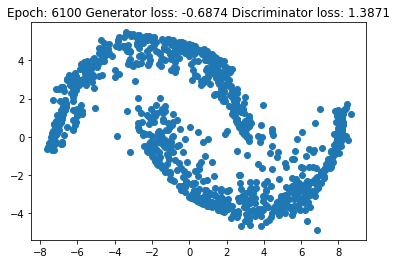

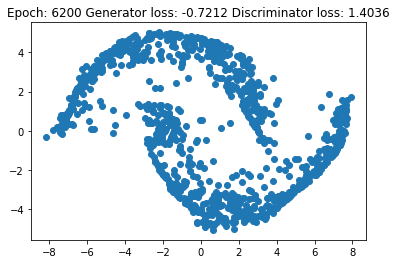

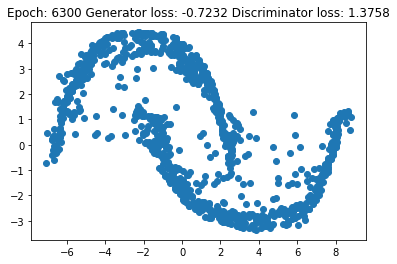

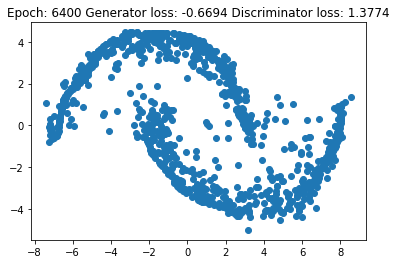

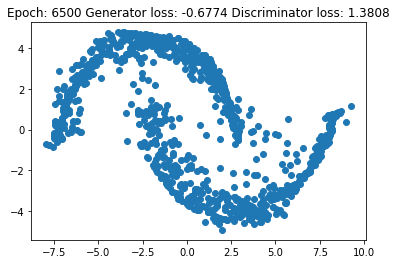

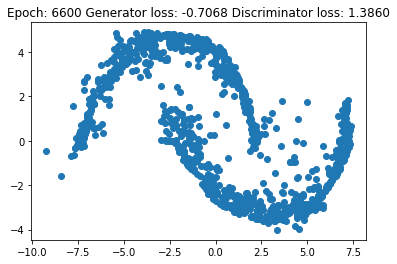

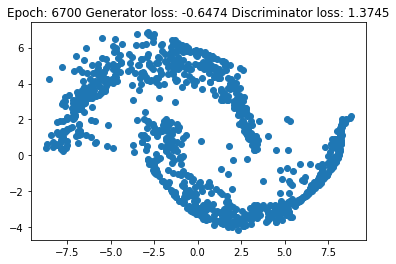

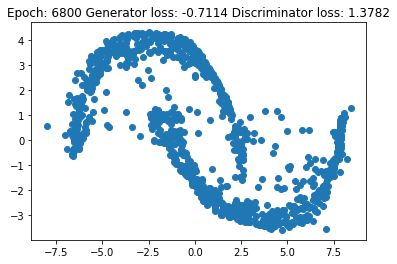

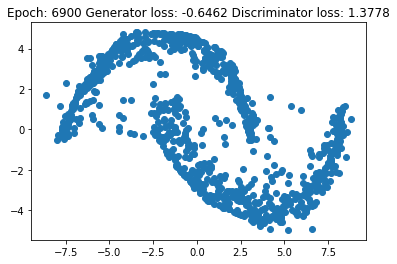

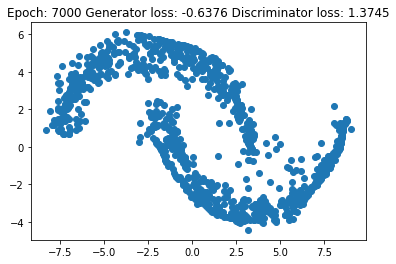

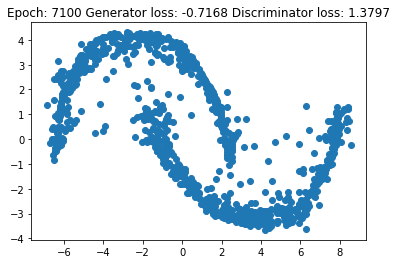

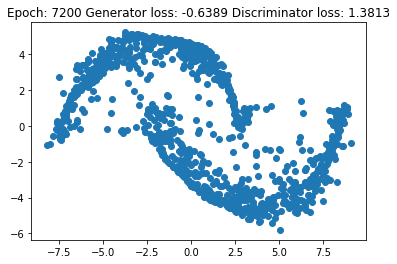

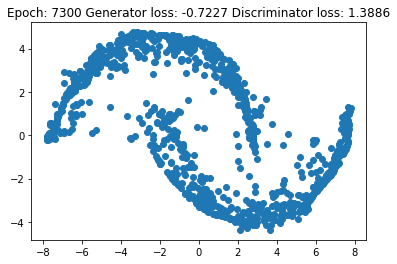

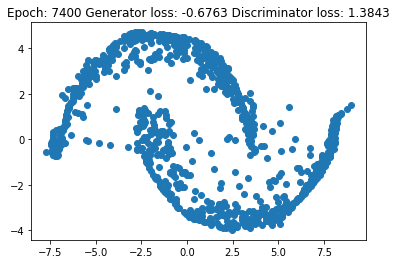

In [ ]:
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G.forward(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D.forward(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(
            D.forward(x),
            D.forward(x_fake_detached)
        )

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                f"Epoch: {i} Generator loss: {G_loss_acc / len(moons) :.4f} Discriminator loss: {D_loss_acc / len(moons) :.4f}"
            )
            plt.show()

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid
x_gen = D.forward(torch.from_numpy(latent_samples).to(device)).detach().to("cpu")
grid_gen = D.forward(torch.from_numpy(latent_grid).to(device)).detach().to("cpu")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Normalizing Flow

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, 0, None], x[:, 1, None]  # x1, x2 = TODO
        if self.odd:
            x1, x2 = x2, x1

        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2 * torch.exp(s) + t

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += s

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, 0, None], z[:, 1, None]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2 - t) * torch.exp(-s)

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [ ]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return torch.mean(-ldetJ - prior_z.log_prob(z))


In [ ]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr)
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

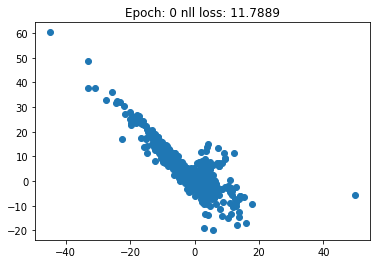

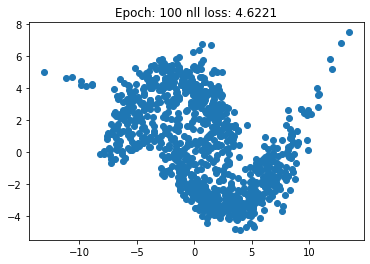

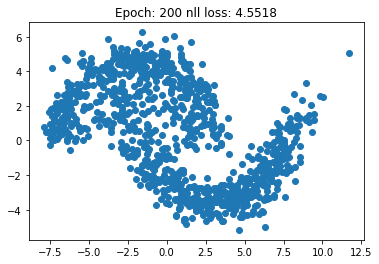

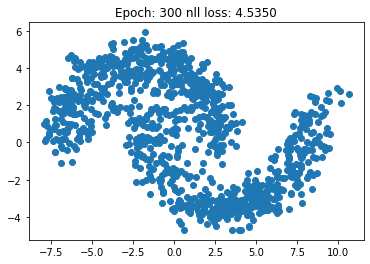

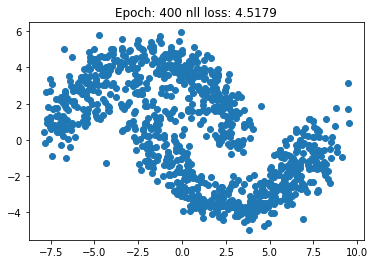

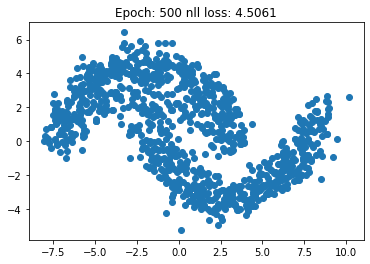

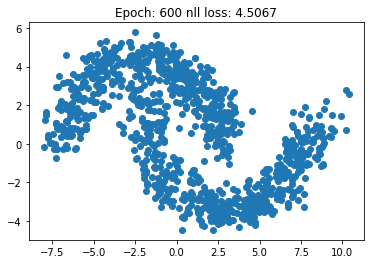

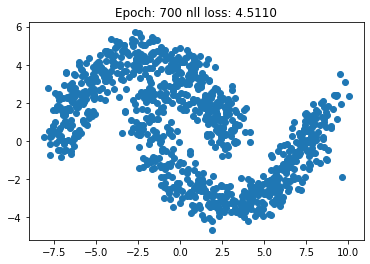

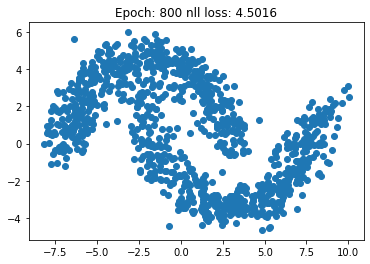

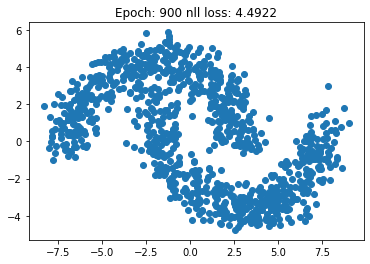

In [ ]:
for i in range(1000):
    loss_acc = 0.0
    flow.train()
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title(f"Epoch: {i} nll loss: {loss_acc / len(moons) :.4f}")
            plt.show()

(-5.0, 5.0)

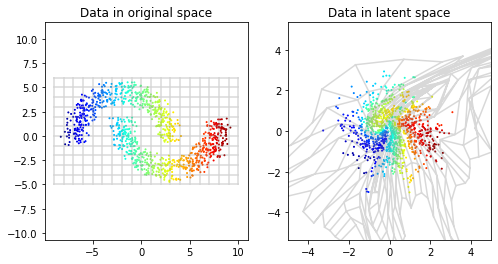

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data and the grid
enc_grid, _ = flow.forward(torch.from_numpy(grid).float().to(device))
enc_data, _ = flow.forward(torch.from_numpy(data).float().to(device))

enc_grid = enc_grid.cpu().detach().numpy()
enc_data = enc_data.cpu().detach().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Text(0.5, 1.0, 'Generated data in original space')

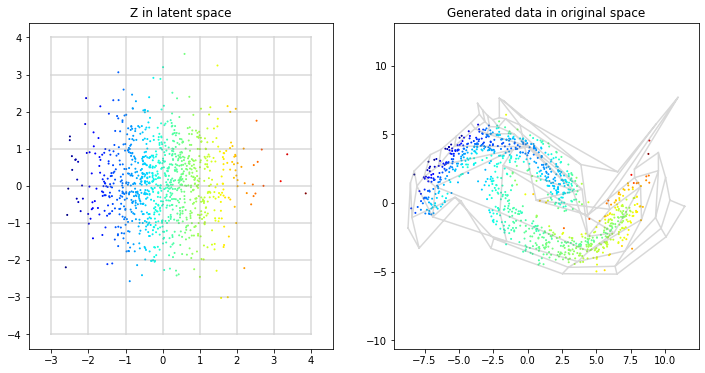

In [ ]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent samples and the grid
x_gen = flow.invert(latent_samples.to(device)).detach().to("cpu").numpy()
grid_gen = flow.invert(torch.from_numpy(latent_grid).float().to(device)).detach().to("cpu").numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Problem 1 answers

### VAE reconstruction loss:

$q_{\phi}(z_i|x_i)$ - encoder

$z_i$ are sampled from $q(z_i|x_i, \phi)$

$p_{\theta}(x_i|z_i)$ decoder

$$
\mathbb{E}_{q_{\phi}(z_i | x_i)} \Big( \log (p(x|z) \Big) \simeq
\frac{1}{L} \sum_{l=1}^L \log p_\theta \Big(x^{(i)} | z^{(i, l)} \Big) = 
$$

## MNIST

In [ ]:
# code from Assignment 2

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
# Monkey-patch MNIST to use a more robust MIST mirror
torchvision.datasets.MNIST.mirrors = [
    # 'http://yann.lecun.com/exdb/mnist/',
    'https://ossci-datasets.s3.amazonaws.com/mnist/',
]

torchvision.datasets.MNIST.resources = [
    (
        "train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]

In [ ]:
# Load the data

batch_size = 512
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


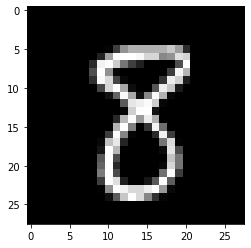

tensor(8)


In [ ]:
import matplotlib.pyplot as plt

for x, y in mnist_loaders["train"]:
  # print(x)
  for x, y in zip(x, y):
    x = x.cpu()
    plt.imshow(x[0], cmap='gray')
    plt.show()
    print(y)
    break
  break

In [ ]:
image_size = 28 * 28

class Generator(nn.Module):
    def __init__(self, in_dim):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
z_dim   = 128
lr      = 0.0001

G = Generator(in_dim=z_dim).to(device)
D = Discriminator().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
D_scheduler = optim.lr_scheduler.ExponentialLR(D_optimizer, gamma=0.999)
G_scheduler = optim.lr_scheduler.ExponentialLR(G_optimizer, gamma=0.999)

In [ ]:
def generator_loss(inputs):
    # print(inputs.shape)
    assert inputs.shape[-1] == 1
    assert len(inputs.shape) == 2
    targets = torch.ones_like(inputs).to(device)
    return nn.BCELoss()(inputs, targets)

def discriminator_loss(inputs, targets):
    return nn.BCELoss()(inputs, targets)

In [ ]:
loader = mnist_loaders["train"]
# batch_size = 128

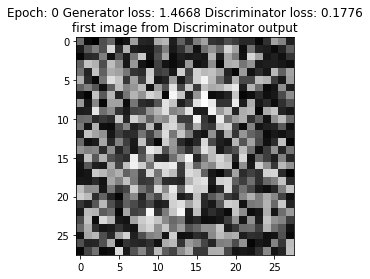

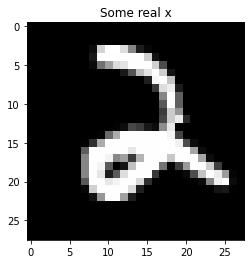

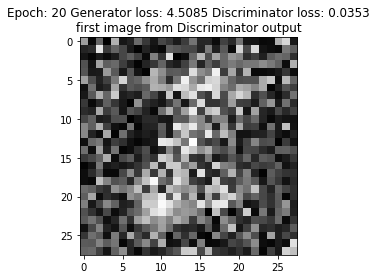

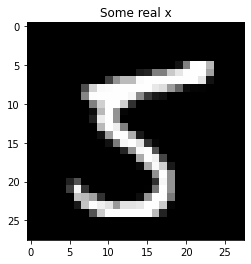

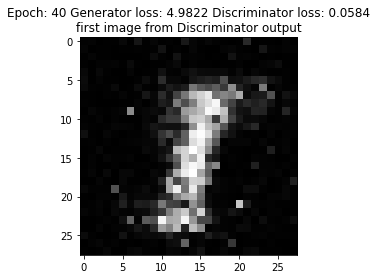

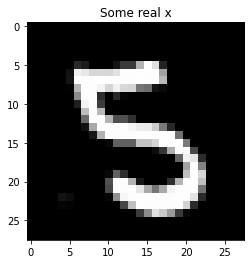

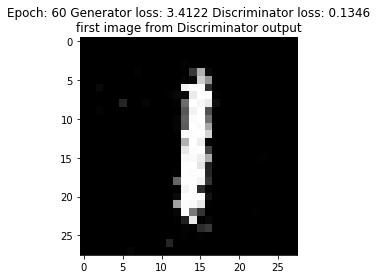

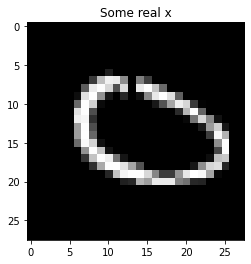

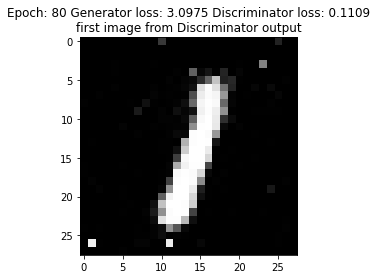

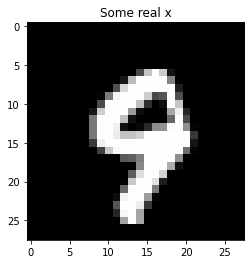

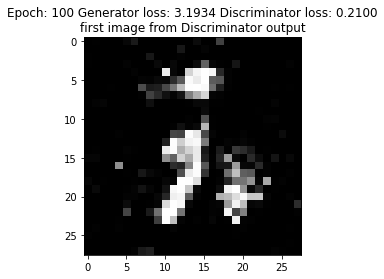

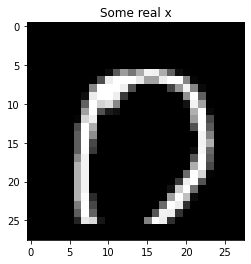

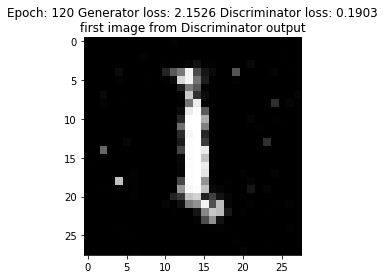

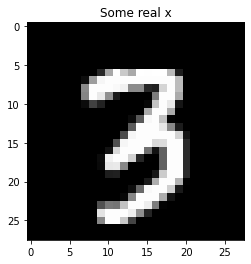

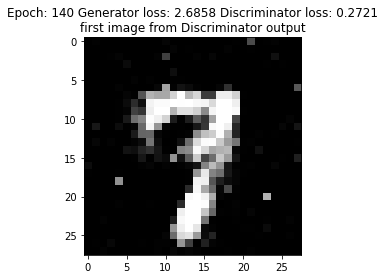

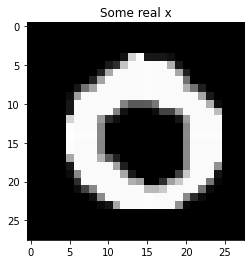

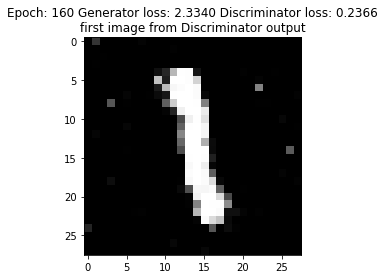

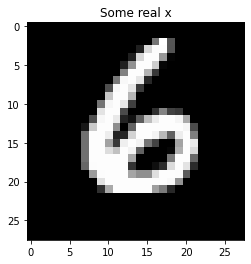

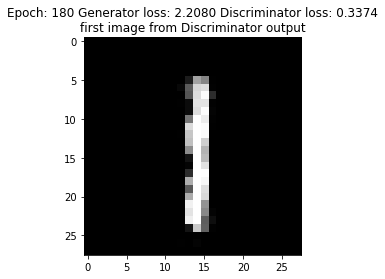

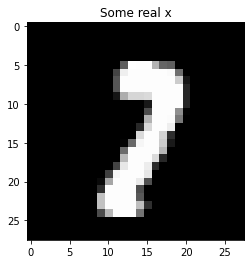

In [ ]:
for i in range(200):
    G.train()
    D.train()
    for x, _ in loader:
        x = x.float().to(device)
        x = x.view(-1, image_size) # -1 to preserve batch size

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        batch_size = x.size(0)
        z = torch.randn(batch_size, z_dim, device=device)
        x_fake = G.forward(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D.forward(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(
            torch.cat(
              (D.forward(x),
              D.forward(x_fake_detached)),
              0
            ),
            torch.cat(
                (torch.ones(x.shape[0], 1).to(device),
                torch.zeros(x_fake_detached.shape[0], 1).to(device)),
                 0
            )
        )

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


    D_scheduler.step()
    G_scheduler.step()

    if i % 20 == 0:
      plt.imshow(x_fake_detached[0].clone().detach().cpu().reshape((28, 28)).numpy(), cmap='gray')
      plt.title(
          f"Epoch: {i} Generator loss: {G_loss.item() :.4f} Discriminator loss: {D_loss.item() :.4f}\nfirst image from Discriminator output"
      )
      plt.show()

      plt.imshow(x[0].clone().detach().cpu().reshape((28, 28)).numpy(), cmap='gray') # ok
      plt.title("Some real x")
      plt.show()

### Some generated digits

In [ ]:
mnist_generate_count = 20

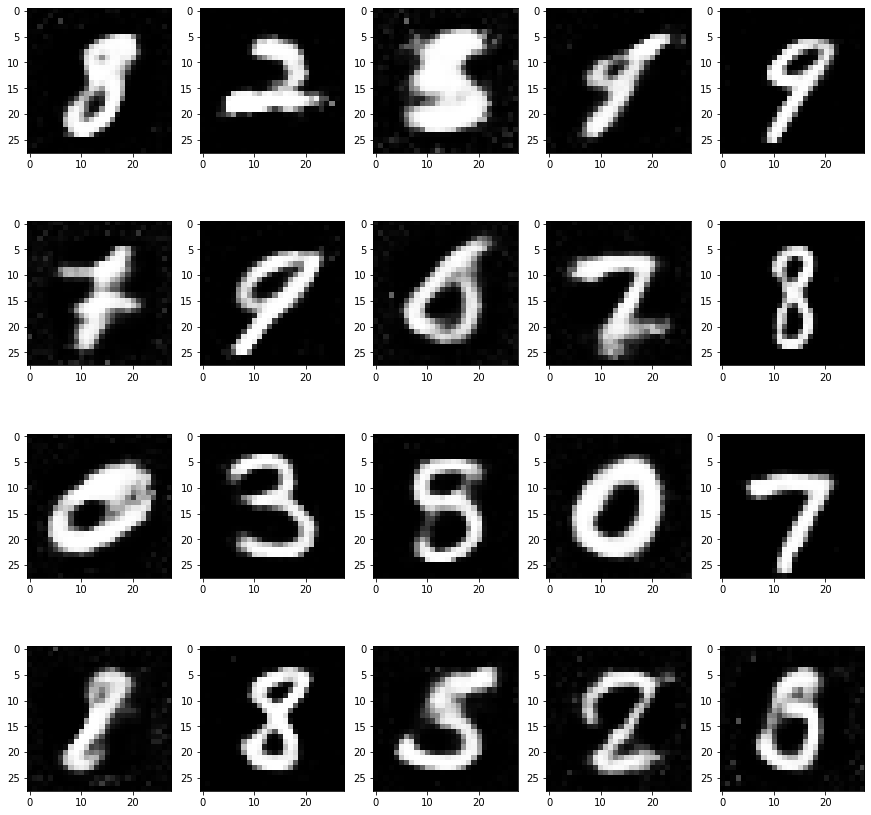

In [ ]:
with torch.no_grad():
  G.eval()
  z = torch.randn(mnist_generate_count, z_dim, device=device)
  x_fake = G.forward(z)  # Use the generator to compute x_Fake
  
  fig = plt.figure(figsize=(15, 15))
  fig.tight_layout(h_pad=5)
  i = 1
  for x_fake in x_fake:
      fig.add_subplot(4, 5, i)
      plt.imshow(x_fake.cpu().reshape((28, 28)).numpy(), cmap='gray') # ok
      i += 1
  plt.show()

#### Interpolating between two fake MNIST latent space points

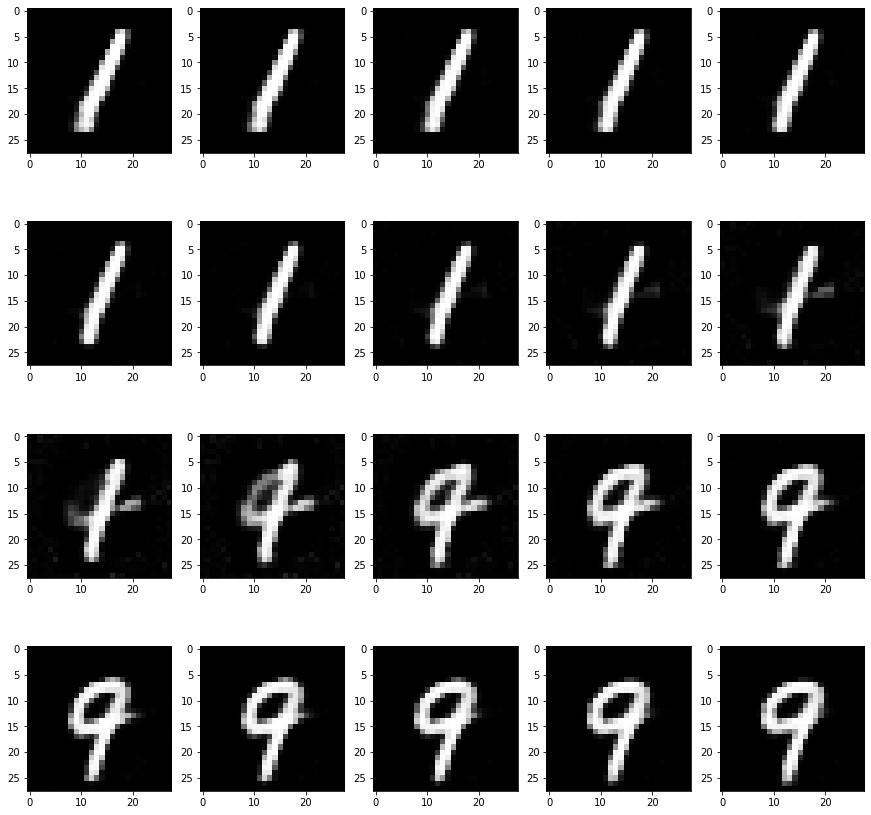

In [ ]:
with torch.no_grad():
  G.eval()
  start, end = torch.randn(1, z_dim, device=device), torch.randn(1, z_dim, device=device)
  step_count = 20
  z = torch.cat(
      [
        start + fade *(end - start)
        for fade in torch.linspace(0.0, 1.0, step_count)
      ]
  )
  x_fake = G.forward(z)  # Use the generator to compute x_Fake

  fig = plt.figure(figsize=(15, 15))
  fig.tight_layout(h_pad=5)
  i = 1
  for x_fake in x_fake:
      fig.add_subplot(4, 5, i)
      plt.imshow(x_fake.cpu().reshape((28, 28)).numpy(), cmap='gray') # ok
      i += 1
  plt.show()

#### Conditional GAN

In [ ]:
image_size = 28 * 28
digit_count = 10

class Generator(nn.Module):
    def __init__(self, in_dim):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(digit_count + in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(digit_count + image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
z_dim   = 128
lr      = 0.0001

G = Generator(in_dim=z_dim).to(device)
D = Discriminator().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
D_scheduler = optim.lr_scheduler.ExponentialLR(D_optimizer, gamma=0.999)
G_scheduler = optim.lr_scheduler.ExponentialLR(G_optimizer, gamma=0.999)

In [ ]:
def generator_loss(inputs):
    # print(inputs.shape)
    assert inputs.shape[-1] == 1
    assert len(inputs.shape) == 2
    targets = torch.ones_like(inputs).to(device)
    return nn.BCELoss()(inputs, targets)

def discriminator_loss(inputs, targets):
    return nn.BCELoss()(inputs, targets)

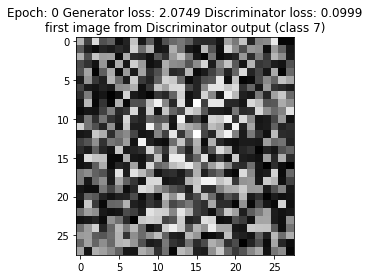

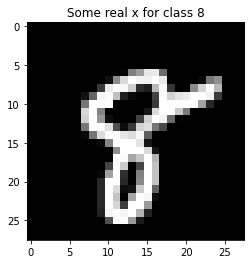

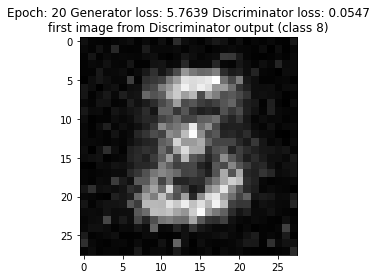

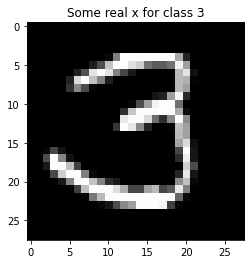

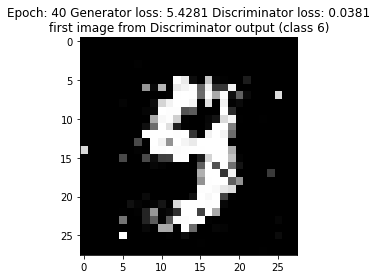

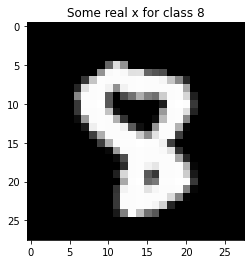

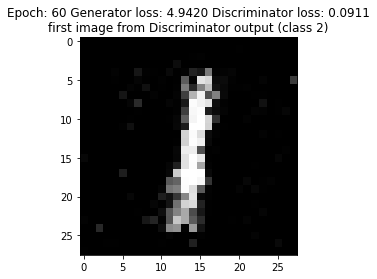

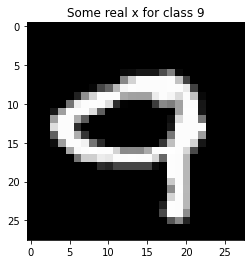

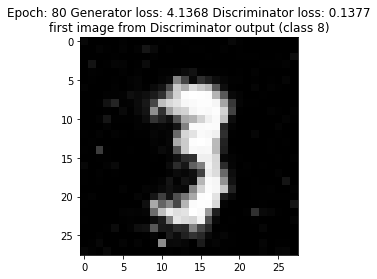

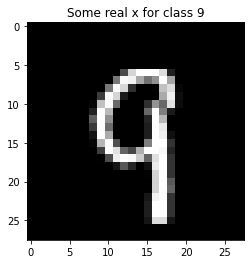

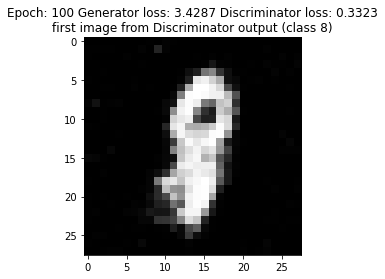

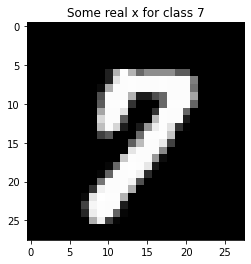

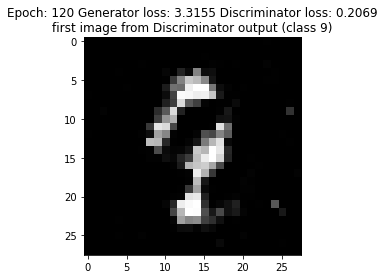

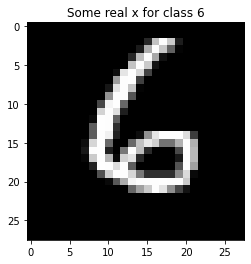

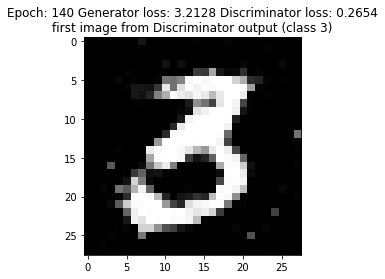

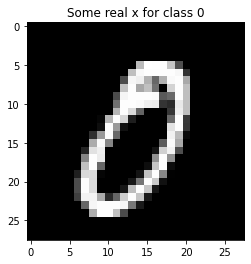

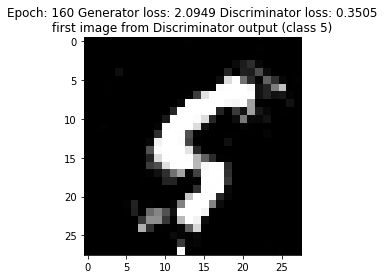

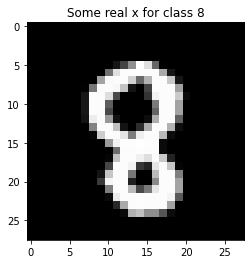

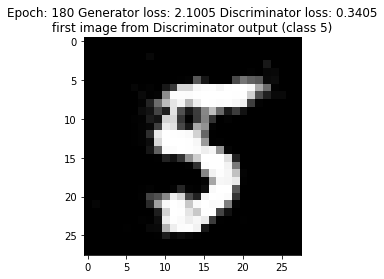

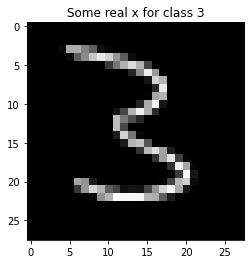

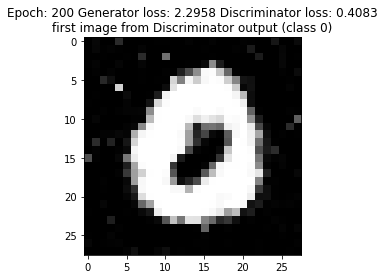

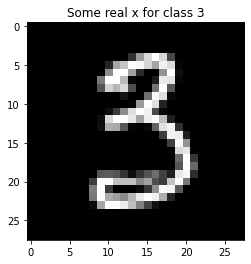

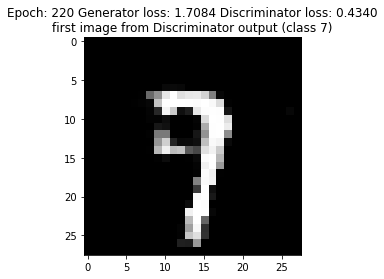

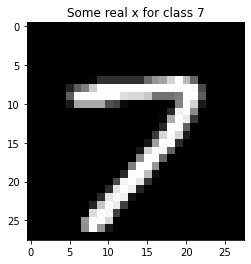

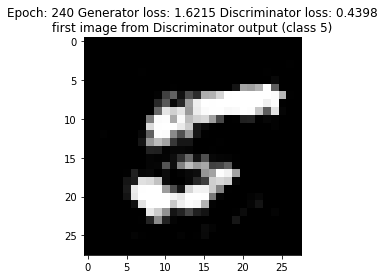

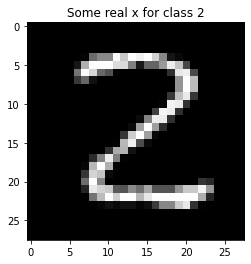

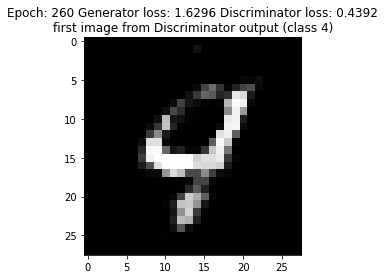

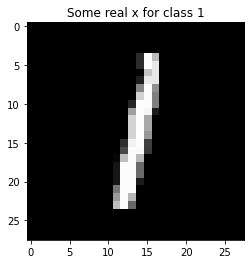

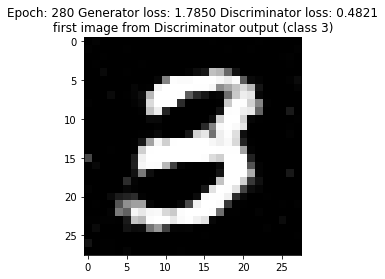

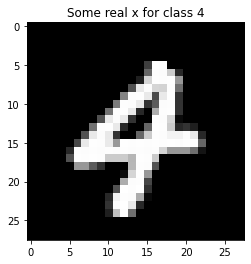

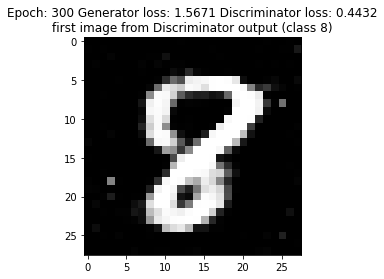

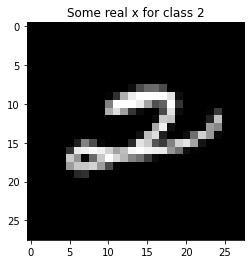

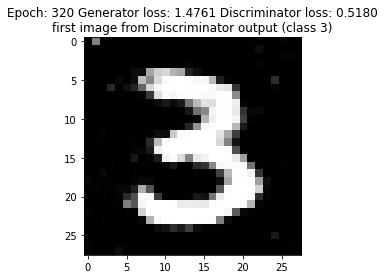

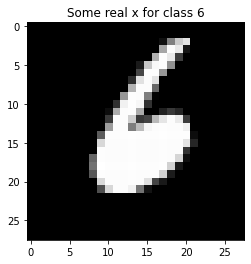

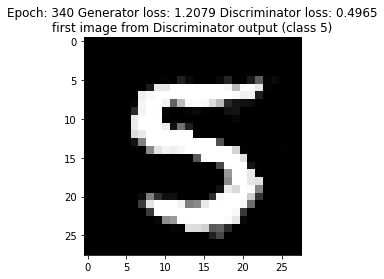

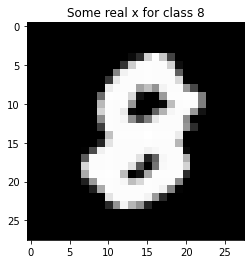

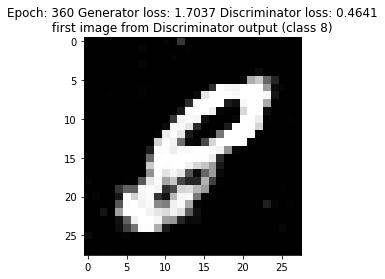

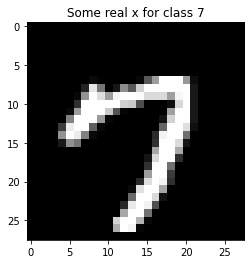

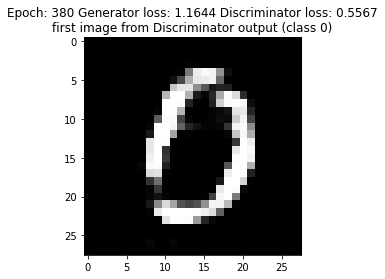

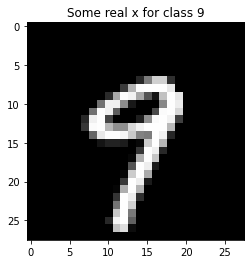

In [ ]:
for i in range(400):
    G.train()
    D.train()
    for x, y in loader:
        x = x.float().to(device)
        x = x.view(-1, image_size) # -1 to preserve batch size

        # Generate fake data from z ~ N(0,1).
        batch_size = x.size(0)
        one_hot_y = torch.nn.functional.one_hot(y, digit_count).float().to(device)
        
        # print(one_hot_y.shape, x.shape)
        x = torch.cat(
            (
                one_hot_y,
                x
            ),
            dim=1
        )

        z = torch.randn(batch_size, z_dim, device=device)

        random_one_hot_y = torch.nn.functional.one_hot(
            torch.randint(low=0, high=digit_count, size=(batch_size,))
        ).float().to(device)

        z = torch.cat(
            (
                random_one_hot_y,
                z
             ),
            dim=1 # prepend digit one hot vector
        )
        x_fake = G.forward(z)  # Use the generator to compute x_fake

        x_fake = torch.cat(
            (
                random_one_hot_y,
                x_fake
            ),
            dim=1
        ) # add digits back to generated x 

        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D.forward(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        D_loss = discriminator_loss(
            torch.cat(
              (D.forward(x),
              D.forward(x_fake_detached)),
              0
            ),
            torch.cat(
                (torch.ones(x.shape[0], 1).to(device),
                torch.zeros(x_fake_detached.shape[0], 1).to(device)),
                 0
            )
        )
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

    D_scheduler.step()
    G_scheduler.step()

    if i % 20 == 0:
      fake_classes, x_fake_detached = torch.split(x_fake_detached, [digit_count, image_size], dim=1) # remove classes from batch, leave images
      plt.imshow(x_fake_detached[0].clone().detach().cpu().reshape((28, 28)).numpy(), cmap='gray')
      plt.title(
          f"Epoch: {i} Generator loss: {G_loss.item() :.4f} Discriminator loss: {D_loss.item() :.4f}\nfirst image from Discriminator output (class {fake_classes[0].argmax()})"
      )
      plt.show()

      real_classes, x = torch.split(x, [digit_count, image_size], dim=1) # remove classes from batch, leave images
      plt.imshow(x[0].clone().detach().cpu().reshape((28, 28)).numpy(), cmap='gray') # ok
      plt.title(f"Some real x for class {real_classes[0].argmax()}")
      plt.show()

In [ ]:
generate_sample_count = 10

### Conditionally generated samples

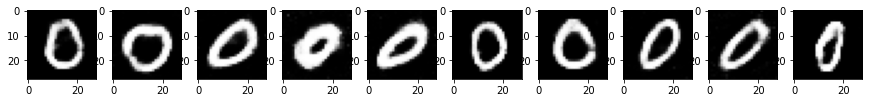

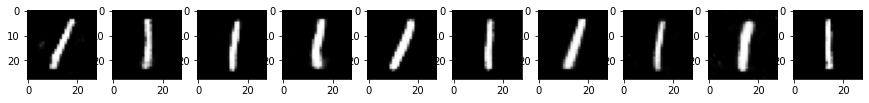

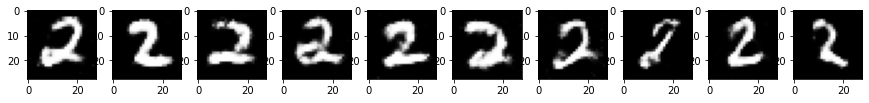

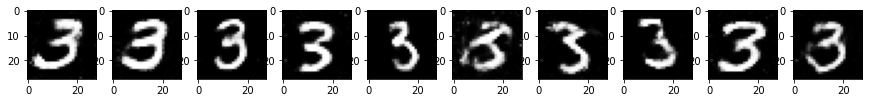

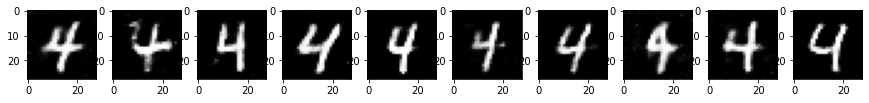

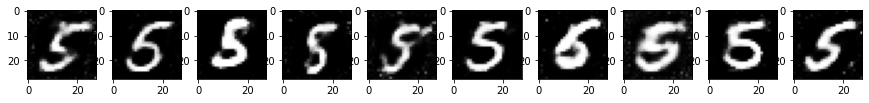

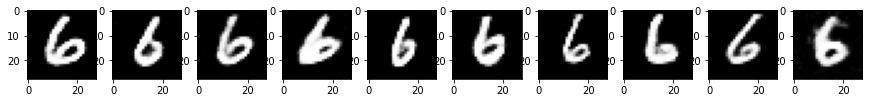

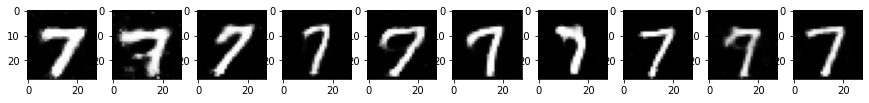

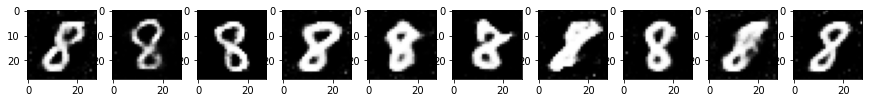

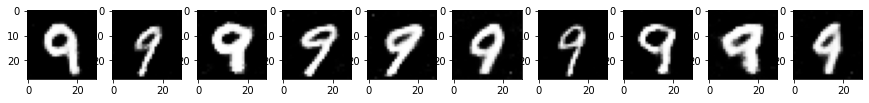

In [ ]:
with torch.no_grad():
  G.eval()
  i = 1
  for digit in range(digit_count):
      z = torch.randn(generate_sample_count, z_dim, device=device)
      y = torch.full((generate_sample_count,), digit)
      one_hot_y = torch.nn.functional.one_hot(y, digit_count).float().to(device)
      
      # print(one_hot_y.shape, x.shape)
      z = torch.cat(
          (
              one_hot_y,
              z
          ),
          dim=1
      )
      x_fake = G.forward(z)  # Use the generator to compute x_fake

      fig = plt.figure(figsize=(15, 15))
      fig.tight_layout(h_pad=5)
      for x_fake in x_fake:
          fig.add_subplot(10, generate_sample_count, i)
          plt.imshow(x_fake.cpu().reshape((28, 28)).numpy(), cmap='gray') # ok
          i += 1
  plt.show()